In [49]:
import pandas as pd

In [50]:
df1 = pd.read_csv("data/cleaned_data.csv")

# EDA

In [51]:
df1["actual_sentiment"].value_counts(normalize=True, dropna=False) * 100

actual_sentiment
positive    43.501124
negative    42.413483
neutral     14.085393
Name: proportion, dtype: float64

In [52]:
df1["rating"].value_counts(normalize=True, dropna=False) * 100

rating
1    32.359551
5    27.577528
4    15.923596
3    14.085393
2    10.053933
Name: proportion, dtype: float64

In [53]:
df1["City"].value_counts(normalize=True, dropna=False) * 100

City
New York             11.775281
Orlando              10.022472
Austin                5.649438
Los Angeles           4.606742
Miami                 4.480899
Dallas                4.422472
Queens                4.274157
Kissimmee             4.224719
Las Vegas             4.170787
Salt Lake City        3.973034
San Diego             3.896629
North Hollywood       3.128090
Honolulu              2.930337
Sunnyvale             2.925843
Fern Park             2.921348
Newark                2.687640
Santa Monica          2.633708
Miami Beach           2.539326
San Antonio           2.525843
Oak Park              2.498876
Champlain             2.485393
Brodheadsville        2.301124
Washington            2.053933
Roanoke               2.013483
Voorhees Township     1.946067
Fort Worth            1.941573
Annandale             0.970787
Name: proportion, dtype: float64

In [54]:
df1["State"].value_counts(normalize=True, dropna=False) * 100

State
FL    24.188764
NY    18.534831
CA    17.191011
TX    16.552809
NJ     4.633708
NV     4.170787
UT     3.973034
HI     2.930337
IL     2.498876
PA     2.301124
DC     2.053933
VA     0.970787
Name: proportion, dtype: float64

# Sentiment Analyser

In [55]:
df2 = df1.copy(deep = True)

## Using NLTK’s Pre-Trained Sentiment Analyzer:

In [56]:
from nltk.sentiment import SentimentIntensityAnalyzer 


analyzer = SentimentIntensityAnalyzer()

#Sentiment score from -1 (very negative) to 1 (very positive)
df2['sentiment_score_SIA'] = df2['tokenized_reviews'].apply(lambda text: analyzer.polarity_scores(str(text))['compound'])
df2['sentiment_SIA'] = None

df2['sentiment_SIA'] = df2['sentiment_score_SIA'].apply(lambda score: 'positive' if score >= 0.4 else ('negative' if score <= -0.1 else 'neutral'))
print(df2[['sentiment_score_SIA', 'sentiment_SIA', 'actual_sentiment', "review"]].head())

   sentiment_score_SIA sentiment_SIA actual_sentiment  \
0               0.5541      positive         negative   
1               0.8591      positive         positive   
2              -0.2960      negative         negative   
3               0.0000       neutral         positive   
4              -0.7184      negative         negative   

                                              review  
0  Why does it look like someone spit on my food?...  
1  It'd McDonalds. It is what it is as far as the...  
2  Made a mobile order got to the speaker and che...  
3  My mc. Crispy chicken sandwich was ..............  
4  I repeat my order 3 times in the drive thru, a...  


<Figure size 800x600 with 0 Axes>

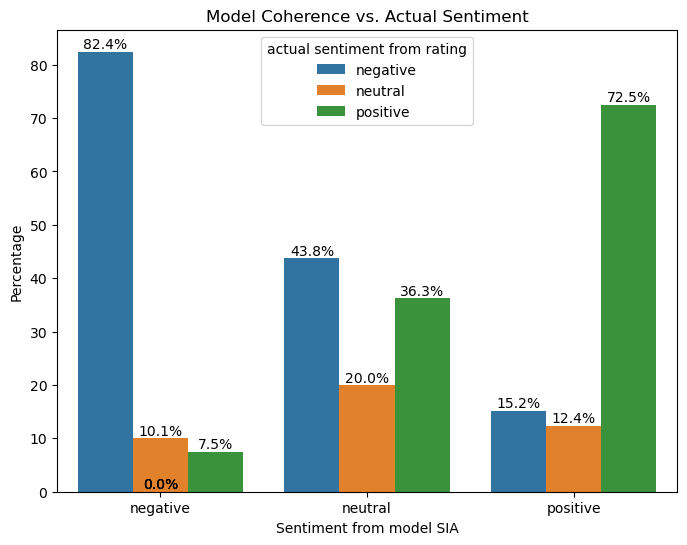

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Compute percentages and convert format for seaborn
rates = df2.groupby(['sentiment_SIA', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100
rates_long = rates.reset_index().melt(id_vars='sentiment_SIA', value_name='percentage')

# Creat graph
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='sentiment_SIA', y='percentage', hue='actual_sentiment')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Model Coherence vs. Actual Sentiment')
plt.xlabel('Sentiment from model SIA')
plt.ylabel('Percentage')
plt.legend(title='actual sentiment from rating')
plt.xticks(rotation=0)

plt.show()

## Model Text_classification from DistilBERT

In [ ]:
from transformers import pipeline
from tqdm.notebook import tqdm

pipe = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512) #model par défaut. tronqué car il ne support pas les reviews de plus de 512 tokens

reviews = df2["review"].tolist()

results = []
for review in tqdm(reviews, desc="Processing reviews"):
    result = pipe(review)
    results.append(result)

df2['DistilBERT'] = results

Device set to use cpu


Processing reviews:   0%|          | 0/22250 [00:00<?, ?it/s]

In [ ]:
df2['DistilBERT'][0]

[{'label': 'NEGATIVE', 'score': 0.9991506338119507}]

In [ ]:
for i in df2.index:
    result = df2.loc[i, "DistilBERT"][0]
    df2.loc[i, "DistilBERT_sentiment"] = result["label"]
    df2.loc[i, "DistilBERT_score"] = result["score"]

df2 = df2.drop(["DistilBERT"], axis=1)

<Figure size 800x600 with 0 Axes>

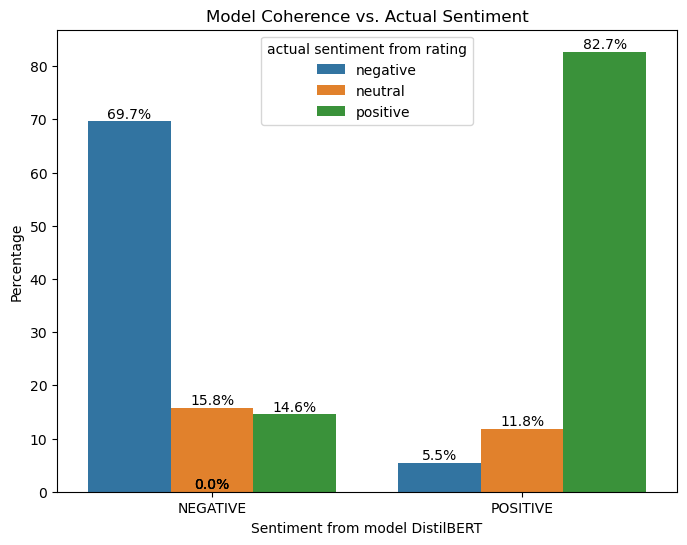

In [ ]:
plt.figure(figsize=(8, 6))

# Calculer les pourcentages
rates = df2.groupby(['DistilBERT_sentiment', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convertir les taux en format long pour seaborn
rates_long = rates.reset_index().melt(id_vars='DistilBERT_sentiment', value_name='percentage')

# Créer le diagramme en bâtons avec seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='DistilBERT_sentiment', y='percentage', hue='actual_sentiment')

# Ajouter des annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Model Coherence vs. Actual Sentiment')
plt.xlabel('Sentiment from model DistilBERT')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='actual sentiment from rating')
plt.show()

## Model RoBERTa

In [40]:
# Load model
from transformers import pipeline

# Initialize the sentiment analysis pipeline
model_roberta = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Users\Myriam\anaconda3\envs\myenv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Myriam\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling 

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
non_string = (df2['clean_reviews'].apply(lambda x: not isinstance(x, str))==True)

In [48]:
df2[non_string]

,reviewer_id,store_address,latitude,longitude,City,State,review,rating,review_date,clean_reviews,tokenized_reviews,actual_sentiment,sentiment_score_SIA,sentiment_SIA,DistilBERT_sentiment,DistilBERT_score,Roberta
571,605,13749 US-183 Hwy,30.460718,-97.792874,Austin,TX,.... ...,5,2022-04-15,NaN,NaN,positive,0.0,neutral,NEGATIVE,0.694801,{}
1964,2765,72-69 Kissena Blvd,40.727401,-73.812460,Queens,NY,............ ...,5,2021-04-15,NaN,NaN,positive,0.0,neutral,NEGATIVE,0.970724,{}
2048,2903,72-69 Kissena Blvd,40.727401,-73.812460,Queens,NY,................ ...,3,2023-04-15,NaN,NaN,neutral,0.0,neutral,NEGATIVE,0.969970,{}
2596,3567,429 7th Ave,40.750506,-73.990583,New York,NY,.................... ...,1,2021-04-15,NaN,NaN,negative,0.0,neutral,NEGATIVE,0.967011,{}
2712,3687,429 7th Ave,40.750506,-73.990583,New York,NY,........ ...,5,2025-01-15,NaN,NaN,positive,0.0,neutral,NEGATIVE,0.963328,{}
3302,4666,724 Broadway,40.729126,-73.993264,New York,NY,# 3,5,2021-04-15,NaN,NaN,positive,0.0,neutral,POSITIVE,0.998685,{}
3466,4899,724 Broadway,40.729126,-73.993264,New York,NY,................................ ...,5,2022-04-15,NaN,NaN,positive,0.0,neutral,NEGATIVE,0.960141,{}
5395,7459,550 Lawrence Expy,37.385495,-121.995421,Sunnyvale,CA,...,3,2022-04-15,NaN,NaN,neutral,0.0,neutral,POSITIVE,0.958502,{}
5533,7647,550 Lawrence Expy,37.385495,-121.995421,Sunnyvale,CA,................,4,2024-08-15,NaN,NaN,positive,0.0,neutral,NEGATIVE,0.971252,{}
6040,8256,11382 US-441,28.399986,-81.405103,Orlando,FL,........,3,2024-09-15,NaN,NaN,neutral,0.0,neutral,NEGATIVE,0.871021,{}


In [ ]:
from tqdm.notebook import tqdm

# Initialiser la colonne "Roberta" avec des dictionnaires vides
df2["Roberta"] = [{} for _ in range(len(df2))]

# Définir la limite de longueur
max_length = 514

# Loop to each review in the dataset, the results are stored in a dictionary
for i, row in tqdm(df3.iterrows(), total=len(df2)):
    try:
        text = row['clean_reviews']

        # Vérifier si text est une chaîne de caractères
        if not isinstance(text, str):
            print(f"Skipping non-string value at index {i}: {text}")
            continue

        myid = i  # Utiliser l'index comme identifiant

        # Tronquer le texte si nécessaire
        if len(text) > max_length:
            text = text[:max_length]

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'RoBerta_{key}'] = value

        df2.at[i, "Roberta"] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

from tqdm.notebook import tqdm

# Initialiser la colonne "Roberta" avec des dictionnaires vides
df2["Roberta"] = [{} for _ in range(len(df2))]

# Définir la limite de longueur
max_length = 514

# Loop to each review in the dataset, the results are stored in a dictionary
for i, row in tqdm(df2.iterrows(), total=len(df2)):
    try:
        text = row['clean_reviews']
        myid = i  # Utiliser l'index comme identifiant

        # Tronquer le texte si nécessaire
        if len(text) > max_length:
            text = text[:max_length]

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'Roberta_{key}'] = value

        df2.at[i, "Roberta"] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

  0%|          | 0/22267 [00:00<?, ?it/s]

TypeError: object of type 'float' has no len()

In [ ]:
df2["Roberta_label"]=None
df2["Roberta_score"]=None
# Itérer sur l'index et les valeurs de la colonne "Roberta"
for i, roberta_dict in df2["Roberta"].items():
    # Vérifier si "RoBerta_label" existe dans le dictionnaire
    if "Roberta_label" in roberta_dict:
        # Mettre à jour la colonne "RoBerta_label" avec la valeur correspondante
        df2.at[i, "Roberta_label"] = roberta_dict["Roberta_label"]
        df2.at[i, "Roberta_score"] = roberta_dict["Roberta_score"]
df2 = df2.drop("Roberta", axis=1)

In [ ]:
# RoBERTa labeled results as: for negative review as LABEL_0, for neutral as LABEL_1, and for positive as LABEL_2
# Below is to map  the Labels as negative , neutral and positive

def map_roberta_labels(label):
    if label == 'LABEL_0':
        return 'negative'
    elif label == 'LABEL_1':
        return 'neutral'
    elif label == 'LABEL_2':
        return 'positive'
    else:
        return 'unknown'

# Apply the function to the 'Roberta_label' column
df2['Roberta_label'] = df2['Roberta_label'].apply(map_roberta_labels)

In [ ]:
df2['Roberta_score'] = df2['Roberta_score'].astype(float)

In [ ]:
df_refults_filtered = df2.copy()

# Group and compute percentages
rates = df_refults_filtered.groupby(['Roberta_label', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='Roberta_label', value_name='percentage', var_name='actual_sentiment')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='Roberta_label', y='percentage', hue='actual_sentiment')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

plt.title('Model Coherence vs. Actual Sentiment')
plt.xlabel('Sentiment from model RoBERTa')
plt.ylabel('Percentage')
plt.legend(title='Actual Review', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


RoBERTA model shows the best results

# Cleaning dataset for dashboard

In [ ]:
df3 = df2.copy(deep=True)

In [ ]:
df3.columns

In [ ]:
df3=df3[["store_address","City","State","longitude","latitude","review_time","review_date","review","clean_reviews","rating","liked","RoBerta_label","RoBerta_score"]]